In [1]:
# Author: Damodar Rajbhandari (2019)

from IPython.display import clear_output, display

# Mounting Google Drive in Collab instance
from google.colab import drive
drive.mount('/content/drive')

clear_output(wait=True)

print("Damodar, Your Google Drive is mounted!!!")

# To goto Nepse MoreRefinedCompanyData folder
# !cd drive/My\ Drive/MoreRefinedCompanyData

Damodar, Your Google Drive is mounted!!!


In [2]:
import os
import math
import json
import numpy as np
import pandas as pd
import datetime as dt
from numpy import newaxis
import matplotlib.pyplot as plt
#!pip install keras

# Requirements
#--------------
# numpy==1.15.0
# pandas==0.23.3
# tensorflow-gpu==1.10.0
# keras==2.2.2
# matplotlib==2.2.2

#clear_output()
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [ ]:
# Creating a DataLoader Class 

class DataLoader():
  """
  A class for loading and transforming data for the LSTM model.
  
  :param filename : name of data sets
  :param split : percentage of the data to use for train vs. test
  :param cols : selecting one or more colums of data (input parameters)
  """
  
  def __init__(self, filename, split, cols):
    dataframe = pd.read_csv(filename).reset_index()
    # how many percentage do I need to set the training data sets
    i_split = int(len(dataframe)*split) 
    # setting data into train and test data sets.
    self.data_train = dataframe.get(cols).values[:i_split]
    self.data_test = dataframe.get(cols).values[i_split:]
    self.len_train = len(self.data_train)
    self.len_test = len(self.data_test)
    self.len_train_windows = None
  
  def normalize_windows(self, window_data, single_window=False):
    """
    Normalize window with a base value of zero.
    Normalization (ni) = (pi/p0) -1
    De-Normalization = pi = p0(ni+1)
    """
    normalized_data = []
    # If single_window=True then, window_data will be [window_data] else window data
    window_data = [window_data] if single_window else window_data
    for window in window_data:
      normalized_window = []
      for col_i in range(window.shape[1]):
        normalized_col = [((float(p) / float(window[0, col_i])) - 1) for p in window[:, col_i]]
        normalized_window.append(normalized_col)
      # reshape and transpose array back into original
      # multidimensional format
      normalized_window = np.array(normalized_window).T 
      normalized_data.append(normalized_window)
    return np.array(normalized_data)

  def _next_window(self, i, seq_len, normalize):
    """
    Generates the next data window from the given index location i.
    """
    window = self.data_train[i:i+seq_len]
    window = self.normalize_windows(window, single_window=True)[0] if normalize else window
    x = window[:-1]
    y = window[-1, [0]]
    return x, y
   
  def get_train_data(self,seq_len, normalize):
    """
    Create x, y train data windows
    
    Warning: batch method, not generative, make sure you have enough memory
    to load data, otherwise use generate_training_window() method.
    
    :param seq_len : window size which allows the network to see shape at each sequencee
    :param normalize : 
    """
    data_x = []
    data_y = []
    for i in range(self.len_train - seq_len):
      x,y = self._next_window(i, seq_len, normalize)
      data_x.append(x)
      data_y.append(y)
    return np.array(data_x), np.array(data_y)
  
  def generate_train_batch(self, seq_len, batch_size, normalize):
    """
    Yield a generator of training data from filename on 
    given list of cols split for train/test.
    """
    i = 0
    while i < (self.len_train - seq_len):
      x_batch = []
      y_batch = []
      for b in range(batch_size):
        if i >= (self.len_train - seq_len):
          # stop-condition for a smaller final batch if data doesn't
          # divide evenly
          yield np.array(x_batch), np.array(y_batch)
          i = 0
        x, y = self._next_window(i, seq_len, normalize)
        x_batch.append(x)
        y_batch.append(y)
        i += 1
      yield np.array(x_batch), np.array(y_batch)
      
  def get_test_data(self, seq_len, normalize):
    """
    Create x, y test data windows
    
    Warning: batch method, not generative, make sure you have enough
    memory to load data, otherwise reduce size of the training split.
    """
    data_windows = []
    for i in range(self.len_test - seq_len):
      data_windows.append(self.data_test[i:i+seq_len])
      
    data_windows = np.array(data_windows).astype(float)
    data_windows = self.normalize_windows(data_windows, single_window=False) if normalize else data_windows
    
    x = data_windows[:, :-1]
    y = data_windows[:, -1, [0]]
    return x,y

In [ ]:
class Timer():
  
  def __init__(self):
    self.start_dt = None
    
  def start(self):
    self.start_dt = dt.datetime.now()
    
  def stop(self):
    end_dt = dt.datetime.now()
    print('Time taken: {}'.format(end_dt - self.start_dt))

In [ ]:
class Model():
  
  def __init__(self):
    self.model = Sequential()
    
  def load_model(self, filepath):
    print('[Model] Loading model from file {}'.format(filepath))
    self.model = load_model(filepath)
  
  def build_model(self, configs):
    timer = Timer()
    timer.start()
    
    for layer in configs['model']['layers']:
      neurons = layer['neurons'] if 'neurons' in layer else None
      dropout_rate = layer['rate'] if 'rate' in layer else None
      activation = layer['activation'] if 'activation' in layer else None
      return_seq = layer['return_seq'] if 'return_seq' in layer else None
      input_timesteps = layer['input_timesteps'] if 'input_timesteps' in layer else None
      input_dim = layer['input_dim'] if 'input_dim' in layer else None
      
      if layer['type'] == 'dense':
        self.model.add(Dense(neurons, activation=activation))
        
      if layer['type'] == 'lstm': 
        self.model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences=return_seq))
        
      if layer['type'] == 'dropout':
        self.model.add(Dropout(dropout_rate))
    
    self.model.compile(loss=configs['model']['loss'], optimizer=configs['model']['optimizer'])
    
    print('[Model] Model Compiled')
    timer.stop()
    
  def train(self, x, y, epochs, batch_size, save_dir):
    timer = Timer()
    timer.start()
    print('[Model] Training Started')
    print('[Model] {} epochs, {} batch size'.format(epochs, batch_size))
    
    save_fname = os.path.join(save_dir, '%s-e%s.h5' % (dt.datetime.now().strftime('%d%m%Y-%H%M%S'), str(epochs)))
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=2),
        ModelCheckpoint(filepath=save_fname, monitor='val_loss', save_best_only=True)
    ]
    
    self.model.fit(
        x,
        y,
        epochs = epochs,
        batch_size = batch_size,
        callbacks = callbacks
    )
    
    self.model.save(save_fname)
    print('[Model] Training Completed. Model saved as {}'.format(save_fname))
    timer.stop()
    
  def train_generator(self, data_gen, epochs, batch_size, steps_per_epoch, save_dir):
    timer = Timer()
    timer.start()
    print('[Model] Training Started')
    print('[Model] {} epochs, {} batch size, {} batches per epoch'.format(epochs, batch_size, steps_per_epoch))
    save_fname = os.path.join(save_dir, '%s-e%s.h5' % (dt.datetime.now().strftime('%d%m%Y-%H%M%S'), str(epochs)))
		
    callbacks = [
        ModelCheckpoint(filepath=save_fname, monitor='loss', save_best_only=True)
		]
    
    self.model.fit_generator(
			data_gen,
			steps_per_epoch=steps_per_epoch,
			epochs=epochs,
			callbacks=callbacks,
			workers=1
		)
    
    print('[Model] Training Completed. Model saved as {}' .format(save_fname))
		
    timer.stop()
    
  def predict_point_by_point(self, data):
		#Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    print('[Model] Predicting Point-by-Point...')
    predicted = self.model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted 
  
  def predict_sequences_multiple(self, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    print('[Model] Predicting Sequences Multiple...')
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
      curr_frame = data[i*prediction_len]
      predicted = []
      for j in range(prediction_len):
        predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
      prediction_seqs.append(predicted)
    return prediction_seqs
  
  def predict_sequence_full(self, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    print('[Model] Predicting Sequences Full...')
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
      predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
      curr_frame = curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    return predicted

In [6]:
ask = input("Which company do you want to visualize?\n")
company = "../content/drive/My Drive/MoreRefinedCompanyData/{}.csv".format(ask)

configuration ={
    "data":{
        "filename": company,
        "columns":[
            "Closing Price",
            "Traded Shares"
        ],
        "sequence_length": int(input("What is the sequence length?\n")), 
        "train_test_split": int(input("What is the percentage of training dataset?\n"))/100,
        "normalize": True        
    },
    "training":{
        "epochs": int(input("What is the number of epochs?\n")),
        "batch_size": int(input("What is the size of batch?\n"))
    },
    "model": {
        "loss": "mse",
        "optimizer": "adam",
        "save_dir": "saved_models",
        "layers": [
            {
                "type": "lstm",
                "neurons": 100,
                "input_timesteps":99,
                "input_dim": 2, 
                "return_seq": True
            },
            {
                "type": "dropout",
                "rate": 0.2
            },
            {
                "type": "lstm",
                "neurons": 100,
                "return_seq": True
            },
            {
                "type": "lstm",
                "neurons": 100,
                "return_seq": False
            },
            {
                "type": "dropout",
                "rate": 0.2
            },
            {
                "type": "dense",
                "neurons": 1,
                "activation": "linear"
            }
        ]
    }
}

# Creating config.json file
with open('config.json','w') as f:
  json.dump(configuration,f, indent=4)

Which company do you want to visualize?
ADBL
What is the sequence length?
100
What is the percentage of training dataset?
80
What is the number of epochs?
5
What is the size of batch?
100


In [7]:
# Opening config.json file.
with open('config.json') as config:
  conf = json.load(config)

conf

{'data': {'columns': ['Closing Price', 'Traded Shares'],
  'filename': '../content/drive/My Drive/MoreRefinedCompanyData/ADBL.csv',
  'normalize': True,
  'sequence_length': 100,
  'train_test_split': 0.8},
 'model': {'layers': [{'input_dim': 2,
    'input_timesteps': 99,
    'neurons': 100,
    'return_seq': True,
    'type': 'lstm'},
   {'rate': 0.2, 'type': 'dropout'},
   {'neurons': 100, 'return_seq': True, 'type': 'lstm'},
   {'neurons': 100, 'return_seq': False, 'type': 'lstm'},
   {'rate': 0.2, 'type': 'dropout'},
   {'activation': 'linear', 'neurons': 1, 'type': 'dense'}],
  'loss': 'mse',
  'optimizer': 'adam',
  'save_dir': 'saved_models'},
 'training': {'batch_size': 100, 'epochs': 5}}

In [ ]:
__author__ = "Damodar Rajbhandari"
__copyright__ = "Damodar Rajbhandari, 2019"
__version__ = "1.0.0"

def plot_results(predicted_data, true_data):
  fig = plt.figure(facecolor='white')
  ax = fig.add_subplot(111)
  ax.plot(true_data, label='True Data')
  plt.plot(predicted_data, label='Prediction')
  plt.legend()
  plt.show()
  
def plot_results_multiple(predicted_data, true_data, prediction_len):
  fig = plt.figure(facecolor='white')
  ax = fig.add_subplot(111)
  ax.plot(true_data, label='True Data')
  # Pad the list of predictions to shift it in the graph to it's correct start
  for i, data in enumerate(predicted_data):
    padding = [None for p in range(i * prediction_len)]
    plt.plot(padding + data, label='Prediction')
    plt.legend()
  plt.show()
  
def main():
  configs = json.load(open('config.json', 'r'))
  if not os.path.exists(configs['model']['save_dir']): os.makedirs(configs['model']['save_dir'])

  data = DataLoader(
        configs['data']['filename'],
        configs['data']['train_test_split'],
        configs['data']['columns']
    )

  model = Model()
  model.build_model(configs)
  x, y = data.get_train_data(
      seq_len=configs['data']['sequence_length'],
      normalize=configs['data']['normalize']
  )

  '''
  # in-memory training
  model.train(
  x,
  y,
  epochs = configs['training']['epochs'],
  batch_size = configs['training']['batch_size'],
  save_dir = configs['model']['save_dir']
  )
  '''
  # out-of memory generative training
  steps_per_epoch = math.ceil((data.len_train - configs['data']['sequence_length']) / configs['training']['batch_size'])
  model.train_generator(
      data_gen=data.generate_train_batch(
        seq_len=configs['data']['sequence_length'],
        batch_size=configs['training']['batch_size'],
        normalize=configs['data']['normalize']
      ),
      epochs=configs['training']['epochs'],
      batch_size=configs['training']['batch_size'],
      steps_per_epoch=steps_per_epoch,
      save_dir=configs['model']['save_dir']
  )

  x_test, y_test = data.get_test_data(
      seq_len=configs['data']['sequence_length'],
      normalize=configs['data']['normalize']
  )

  predictions = model.predict_sequences_multiple(x_test, configs['data']['sequence_length'], configs['data']['sequence_length'])
  # predictions = model.predict_sequence_full(x_test, configs['data']['sequence_length'])
  # predictions = model.predict_point_by_point(x_test)

  plot_results_multiple(predictions, y_test, configs['data']['sequence_length'])
  # plot_results(predictions, y_test)


W0822 15:33:24.070776 140237384484736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0822 15:33:24.108107 140237384484736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0822 15:33:24.118472 140237384484736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0822 15:33:24.394551 140237384484736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0822 15:33:24.403601 

[Model] Model Compiled
Time taken: 0:00:00.980816
[Model] Training Started
[Model] 5 epochs, 100 batch size, 16 batches per epoch


W0822 15:33:25.689887 140237384484736 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0822 15:33:27.787187 140237384484736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/5
16/16 [==============================] - 14s 874ms/step - loss: 0.0801
Epoch 2/5
16/16 [==============================] - 8s 527ms/step - loss: 0.1051
Epoch 3/5
16/16 [==============================] - 8s 527ms/step - loss: 0.0305
Epoch 4/5
16/16 [==============================] - 8s 527ms/step - loss: 0.0298
Epoch 5/5
16/16 [==============================] - 8s 524ms/step - loss: 0.0371
[Model] Training Completed. Model saved as saved_models/22082019-153325-e5.h5
Time taken: 0:00:50.901388
[Model] Predicting Sequences Multiple...


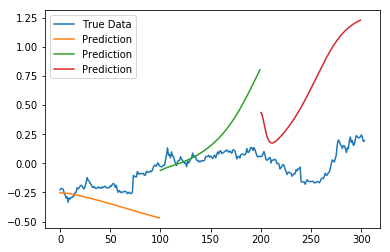

In [9]:
# Train the Neural Network
main()

In [ ]:
"""
import h5py
with h5py.File('input/file.hdf5', 'r') as f:
    x_data = f['x_data']
    model.predict(x_data)
    
"""

"\nimport h5py\nwith h5py.File('input/file.hdf5', 'r') as f:\n    x_data = f['x_data']\n    model.predict(x_data)\n    \n"

In [10]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single pti ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	: 1
vendor_id	: G